In [1]:
import os
import re
from PIL import Image, ImageFilter
import numpy as np
import cv2
import pathlib
import tensorflow as tf
# Function to highlight the forged part in the image

In [2]:

def highlight_forgery(subtracted_array):
    gray_img = cv2.cvtColor(subtracted_array, cv2.COLOR_RGB2GRAY)
    _, thresholded_img = cv2.threshold(gray_img, 30, 255, cv2.THRESH_BINARY)
    edges = cv2.Canny(thresholded_img, 100, 200)
    highlighted_img = cv2.applyColorMap(edges, cv2.COLORMAP_JET)
    result = cv2.addWeighted(subtracted_array, 0.7, highlighted_img, 0.3, 0)
    return result

# Function to resize and subtract two images, and highlight the forgery
def subtract_images(image1_path, image2_path, size=(128, 128)):
    try:
        img1 = Image.open(image1_path).convert('RGB')
        img2 = Image.open(image2_path).convert('RGB')
        img1 = img1.resize(size)
        img2 = img2.resize(size)
        img1_array = np.asarray(img1, dtype=np.int32)
        img2_array = np.asarray(img2, dtype=np.int32)
        subtracted_array = np.clip(np.abs(img1_array - img2_array), 0, 255).astype(np.uint8)
        highlighted_array = highlight_forgery(subtracted_array)
        return highlighted_array
    except Exception as e:
        print(f"Error subtracting images: {e}")
        return None

# Function to find matching images by pattern
def find_image_pairs(au_directory, tp_directory, au_pattern, tp_pattern):
    authentic_images = {}
    tampered_images = []
    au_regex = re.compile(au_pattern)
    tp_regex = re.compile(tp_pattern)
    for filename in os.listdir(au_directory):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.tiff')):
            match = au_regex.search(filename)
            if match:
                prefix = match.group(1)
                symbol = match.group(2)
                authentic_images[(prefix, symbol)] = os.path.join(au_directory, filename)
    for filename in os.listdir(tp_directory):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.tiff', '.tif')):
            tampered_images.append(os.path.join(tp_directory, filename))
    return authentic_images, tampered_images

# Function to process matching images and append them to the dataset
def process_images(au_directory, tp_directory, au_pattern, tp_pattern, size=(128, 128)):
    authentic_images, tampered_images = find_image_pairs(au_directory, tp_directory, au_pattern, tp_pattern)
    X, y = [], []
    for tampered_img in tampered_images:
        tampered_filename = os.path.basename(tampered_img)
        # print(tampered_filename)
        tampered_match = re.search(tp_pattern, tampered_filename)
        # print(tampered_match)
        if tampered_match:
            tp_prefix1 = tampered_match.group(1)
            tp_symbol1 = tampered_match.group(2)
            tp_prefix2 = tampered_match.group(3)
            tp_symbol2 = tampered_match.group(4)
            matching_auth_img1 = authentic_images.get((tp_prefix1, tp_symbol1), None)
            matching_auth_img2 = authentic_images.get((tp_prefix2, tp_symbol2), None)
            # print(matching_auth_img1)

            if matching_auth_img1:
                processed_img1 = subtract_images(matching_auth_img1, tampered_img, size=size)
                if processed_img1 is not None:
                    X.append(processed_img1)
                    y.append(1)  # Label for forged

            if matching_auth_img2:
                processed_img2 = subtract_images(matching_auth_img2, tampered_img, size=size)
                if processed_img2 is not None:
                    X.append(processed_img2)
                    y.append(1)  # Label for forged
            if not matching_auth_img1 and matching_auth_img2:
                print(f"No matching authentic image found for tampered image: {tampered_filename}")
    return np.array(X), np.array(y)




In [3]:
# Define directories and patterns
# au_directory = '/home/nishma/My Project/College_thesis/IFD/archive/small_dataset/Au'
# tp_directory = '/home/nishma/My Project/College_thesis/IFD/archive/small_dataset/Tp'

au_directory = '/Users/logpoint/Documents/SoftwareProjects/Thesis/CASIA22/Au'
tp_directory = '/Users/logpoint/Documents/SoftwareProjects/Thesis/CASIA22/Tp'

au_pattern = r'Au_([a-z]{3})_(\d{5})'
tp_pattern = r'([a-z]{3})(\d{5})_([a-z]{3})(\d{5})'
size = (128, 128)

# Process images
X, y = process_images(au_directory, tp_directory, au_pattern, tp_pattern, size=size)

# Output shape
print(X.shape, y.shape)

No matching authentic image found for tampered image: Tp_D_NRN_S_N_nat10139_ani00005_11950.jpg
No matching authentic image found for tampered image: Tp_D_NRN_S_O_nat10159_ani00084_12055.jpg
No matching authentic image found for tampered image: Tp_D_CRN_S_N_nat10164_ani00005_12093.jpg
No matching authentic image found for tampered image: Tp_D_CRN_S_N_nat10145_ani00099_11990.jpg
No matching authentic image found for tampered image: Tp_D_NRN_S_N_nat10162_art00021_12086.jpg
No matching authentic image found for tampered image: Tp_D_NRN_S_N_nat10146_pla00020_12071.jpg
No matching authentic image found for tampered image: Tp_D_NRN_M_N_nat10144_nat00059_11969.jpg
No matching authentic image found for tampered image: Tp_D_CRN_S_N_nat10159_ani00005_12053.jpg
No matching authentic image found for tampered image: Tp_D_NRN_M_N_nat10145_cha00070_11991.jpg
No matching authentic image found for tampered image: Tp_D_NRN_M_N_nat10167_cha00070_12103.jpg
No matching authentic image found for tampered ima

In [4]:

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load the MobileNetV2 model with pre-trained weights, excluding the top layers
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional base of the model to retain pre-trained weights during initial training
base_model.trainable = False

# Create the model architecture by adding custom layers on top of MobileNetV2
inputs = tf.keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Now you can proceed with the training and validation split
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

# Now you can use the `train_images` and `train_labels` in your model training code
history = model.fit(train_images, train_labels,
                    validation_data=(test_images, test_labels),
                    epochs=10)

model.save('exported/nov_10_ela.h5')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    20,972,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,755,841 (90.62 MB)

 Trainable params: 21,497,857 (82.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 76s 296ms/step - accuracy: 0.9700 - loss: 0.0731 - val_accuracy: 1.0000 - val_loss: 5.4663e-06
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 69s 278ms/step - accuracy: 1.0000 - loss: 1.0590e-04 - val_accuracy: 1.0000 - val_loss: 4.6718e-07
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 87s 353ms/step - accuracy: 1.0000 - loss: 3.1400e-05 - val_accuracy: 1.0000 - val_loss: 1.4351e-07
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 69s 281ms/step - accuracy: 1.0000 - loss: 1.6523e-05 - val_accuracy: 1.0000 - val_loss: 4.8751e-08
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 72s 291ms/step - accuracy: 1.0000 - loss: 1.1077e-05 - val_accuracy: 1.0000 - val_loss: 2.8160e-08
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 80s 322ms/step - accuracy: 1.0000 - loss: 3.6247e-06 - val_accuracy: 1.0000 - val_loss: 1.9403e-08
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 89s 357ms/step - accuracy: 1.0000 - loss: 3.3969e-06 - val_accuracy: 1.0000 - val_loss: 1.3519e-08
Epoch 8/10
247/247 ━━━━━━━━━━━━

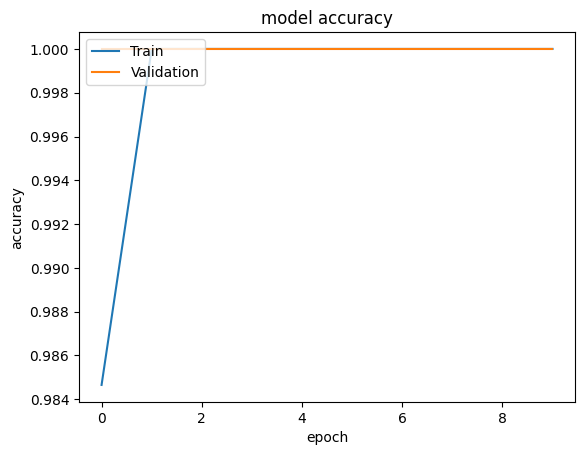

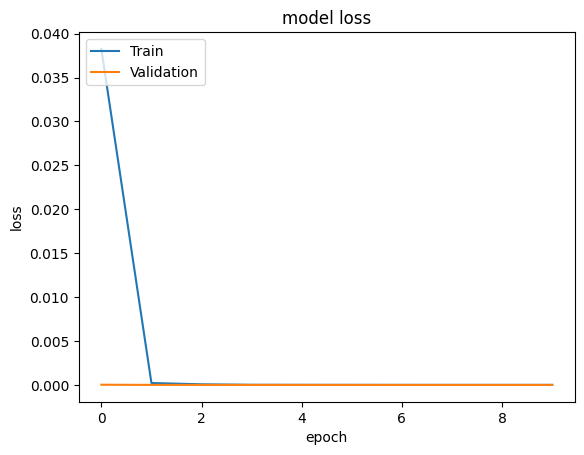

In [9]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()